YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  503 of 503 completed

6 Failed downloads:
['SW', 'KVUE', 'VLTO', 'SOLV', 'GEV']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-01-01 -> 2023-01-01) (Yahoo error = "Data doesn\'t exist for startDate = 1577854800, endDate = 1672549200")')
['WDC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-01-01 -> 2023-01-01)')


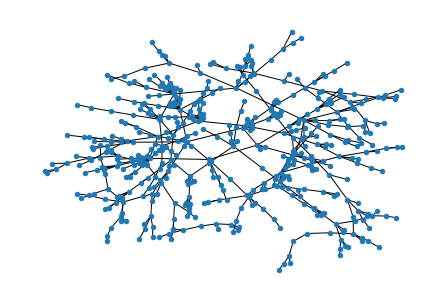

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.sparse.csgraph import minimum_spanning_tree
import networkx as nx
import matplotlib.pyplot as plt

# Step 1: Fetch data
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
tables = pd.read_html(url)
sp500_table = tables[0]
tickers = sp500_table['Symbol'].tolist()
# Fix ticker formats for yfinance (e.g., BRK.B -> BRK-B)
tickers = [ticker.replace('.', '-') for ticker in tickers]
data = yf.download(tickers, start="2020-01-01", end="2023-01-01")["Close"]

# Step 2: Clean data
data = data.dropna(axis=1, thresh=int(0.95 * len(data)))  # Remove stocks with >5% missing
data = data.ffill().bfill()  # Fill gaps

# Step 3: Compute returns
returns = np.log(data / data.shift(1)).dropna()

# Step 4: Correlation matrix
corr_matrix = returns.corr().values

# Step 5: Distance matrix
distance_matrix = np.sqrt(2 * (1 - corr_matrix))

# Step 6: Build MST
mst = minimum_spanning_tree(distance_matrix)
mst_graph = nx.from_scipy_sparse_array(mst)

# Step 7/8: Visualization and analysis
nx.draw(mst_graph, with_labels=False, node_size=20)
plt.show()

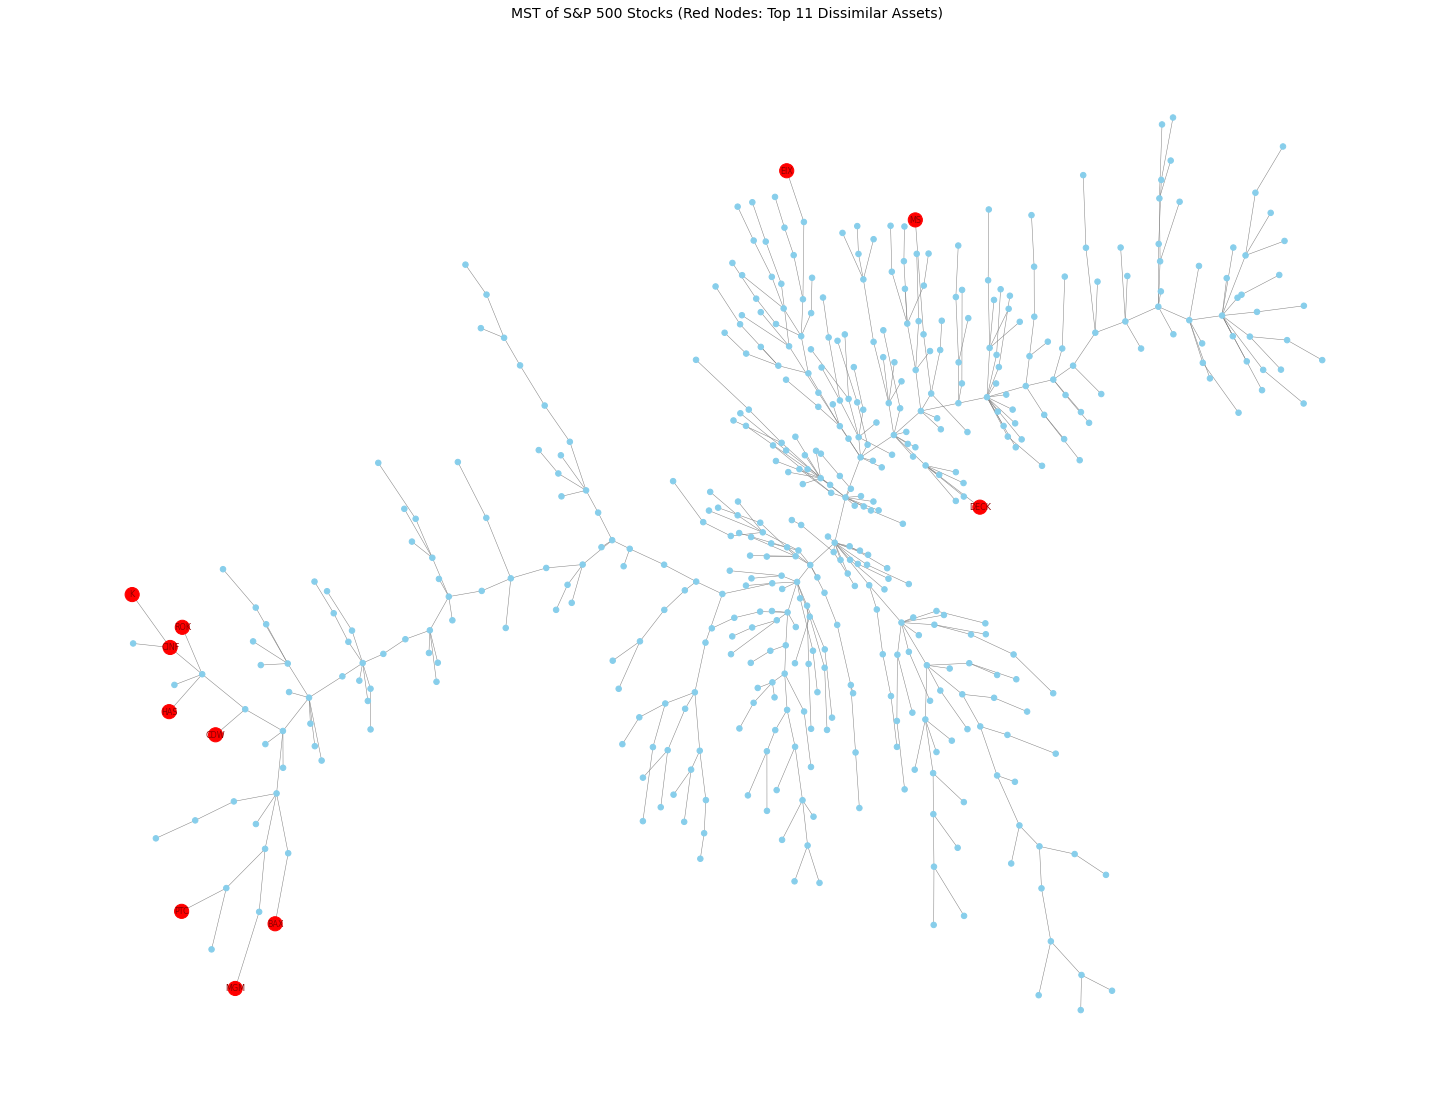

Selected Assets: ['HAS', 'PTC', 'DECK', 'BAX', 'ROK', 'EIX', 'CINF', 'MS', 'CDW', 'K', 'MGM']


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.sparse.csgraph import minimum_spanning_tree
import networkx as nx
import matplotlib.pyplot as plt

'''# Step 1: Fetch data
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
tables = pd.read_html(url)
sp500_table = tables[0]
tickers = sp500_table['Symbol'].tolist()
# Fix ticker formats for yfinance (e.g., BRK.B -> BRK-B)
tickers = [ticker.replace('.', '-') for ticker in tickers]
data = yf.download(tickers, start="2020-01-01", end="2023-01-01")["Close"]'''

# Step 2: Clean data
data = data.dropna(axis=1, thresh=int(0.95 * len(data)))  # Remove stocks with >5% missing
data = data.ffill().bfill()  # Fill gaps

# Step 3: Compute returns
returns = np.log(data / data.shift(1)).dropna()

# Step 4: Correlation matrix
corr_matrix = returns.corr().values

# Step 5: Distance matrix
distance_matrix = np.sqrt(2 * (1 - corr_matrix))

# Step 6: Build MST
mst = minimum_spanning_tree(distance_matrix)
mst_graph = nx.from_scipy_sparse_array(mst)

# Step 7: Select top 11 assets by average dissimilarity
average_dissimilarity = distance_matrix.mean(axis=1)
top_indices = np.argsort(average_dissimilarity)[-11:]
selected_tickers = [tickers[i] for i in top_indices]

# Step 8: Visualize MST with highlighted assets
plt.figure(figsize=(20, 15))

# Assign node colors/sizes based on selection
node_colors = ['red' if i in top_indices else 'skyblue' for i in mst_graph.nodes()]
node_sizes = [200 if i in top_indices else 30 for i in mst_graph.nodes()]

# Draw the MST
pos = nx.kamada_kawai_layout(mst_graph)  # Force-directed layout
nx.draw(mst_graph, pos, with_labels=False, node_color=node_colors, node_size=node_sizes,
        edge_color='gray', width=0.5)

# Label selected nodes (optional)
labels = {i: tickers[i] for i in top_indices}  # Show ticker names for selected nodes
nx.draw_networkx_labels(mst_graph, pos, labels, font_size=8, font_color='darkred')

# Add legend/annotations
plt.title("MST of S&P 500 Stocks (Red Nodes: Top 11 Dissimilar Assets)", fontsize=14)
plt.show()

# Print selected assets
print("Selected Assets:", selected_tickers)

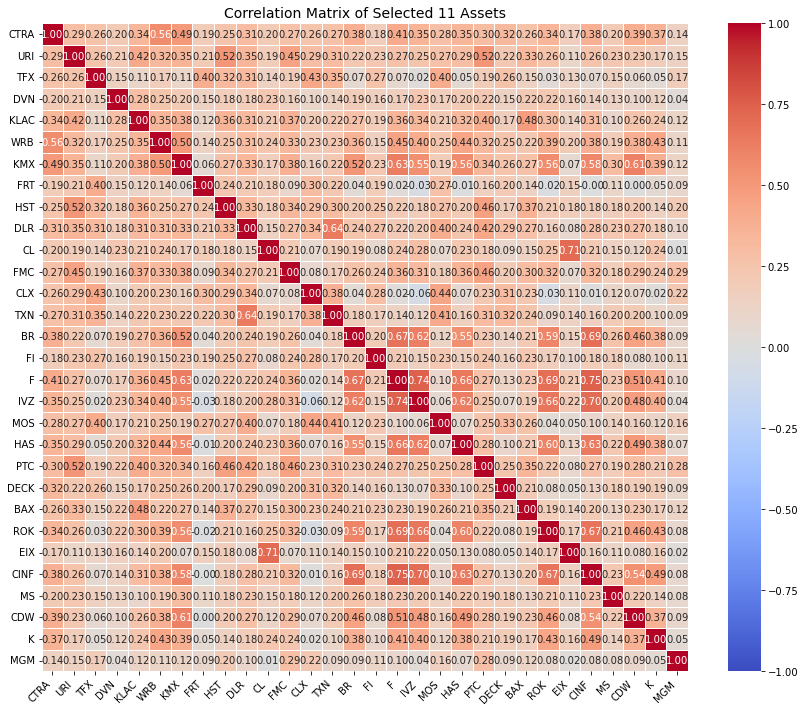

In [ ]:
# Get indices of selected assets in the original correlation matrix
selected_indices = [tickers.index(ticker) for ticker in selected_tickers]

# Subset the correlation matrix
subset_corr = corr_matrix[np.ix_(selected_indices, selected_indices)]

import seaborn as sns

plt.figure(figsize=(12, 10))

# Create a mask to hide the upper triangle (optional)
mask = np.triu(np.ones_like(subset_corr, dtype=bool))

# Plot heatmap
sns.heatmap(
    subset_corr,
    annot=True,            # Show correlation values
    fmt=".2f",             # Format annotations to 2 decimals
    cmap="coolwarm",       # Red (positive) to blue (negative) colormap
    vmin=-1, vmax=1,       # Fix scale from -1 to 1
    #mask=mask,             # Optional: hide upper triangle
    xticklabels=selected_tickers,
    yticklabels=selected_tickers,
    linewidths=0.5,
)

# Customize plot
plt.title("Correlation Matrix of Selected 11 Assets", fontsize=14)
plt.xticks(rotation=45, ha="right")  # Rotate x-labels
plt.tight_layout()
plt.show()

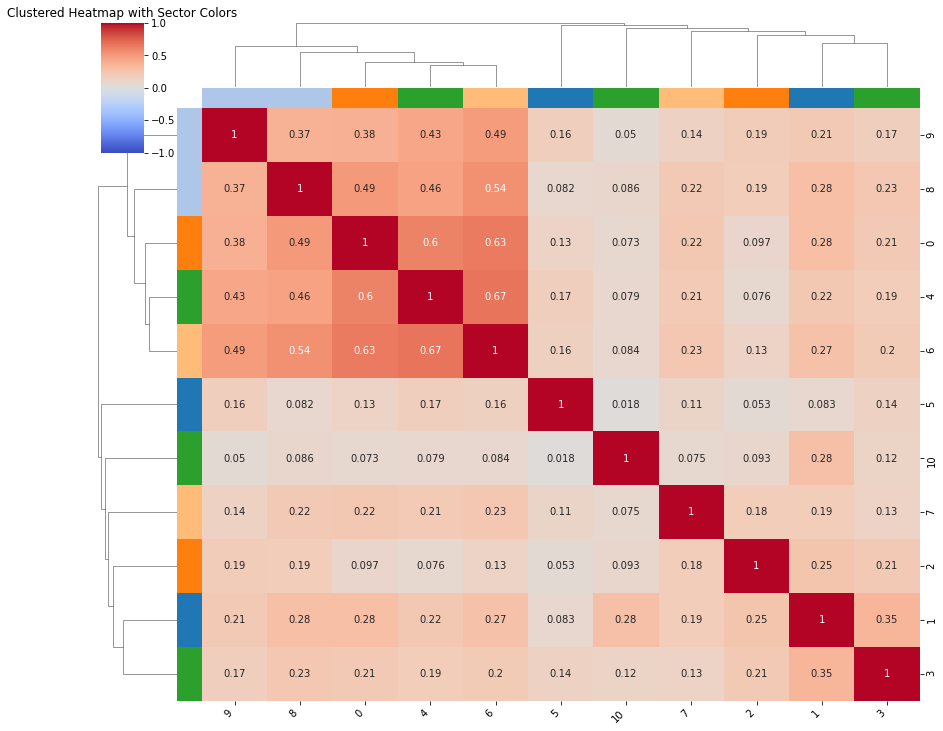

In [ ]:
# Fetch sector data for selected assets
sector_info = {}
for ticker in selected_tickers:
    try:
        stock = yf.Ticker(ticker)
        sector_info[ticker] = stock.info.get('sector', 'Unknown')
    except:
        sector_info[ticker] = 'Unknown'

# Create color mapping for sectors
unique_sectors = list(set(sector_info.values()))
palette = sns.color_palette("tab20", len(unique_sectors))
sector_to_color = {sector: palette[i] for i, sector in enumerate(unique_sectors)}

# Assign colors to rows/columns
row_colors = [sector_to_color[sector_info[ticker]] for ticker in selected_tickers]
col_colors = [sector_to_color[sector_info[ticker]] for ticker in selected_tickers]

# Plot clustered heatmap with sector colors
clustered = sns.clustermap(
    subset_corr,
    cmap="coolwarm",
    row_colors=row_colors,
    col_colors=col_colors,
    figsize=(12, 10),
    annot=True,
    vmin=-1, vmax=1,
    dendrogram_ratio=0.1,
)
plt.setp(clustered.ax_heatmap.get_xticklabels(), rotation=45, ha="right")
plt.title("Clustered Heatmap with Sector Colors")
plt.show()